## Seminar 11. Reinforcement Learning.





In [ ]:
!pip install gymnasium

In [ ]:
import sys, os

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

from dataclasses import dataclass
import typing as tt
from typing import List

import torch
import torch.nn as nn
import torch.optim as optim

import gymnasium as gym

%matplotlib inline

Let's briefly recall RL method taxonomy. We mentioned some models for context, but we won't go into detail, as this is not a dedicated RL course. There are two main types of model-free RL methods:

1. **Policy-based methods**: Train the policy directly to learn which action $a$ to take given a state $s$.

2. **Value-based methods**: Train a value function to learn which state $s$ is more valuable and use this value function to take the action $a$ that leads to it.

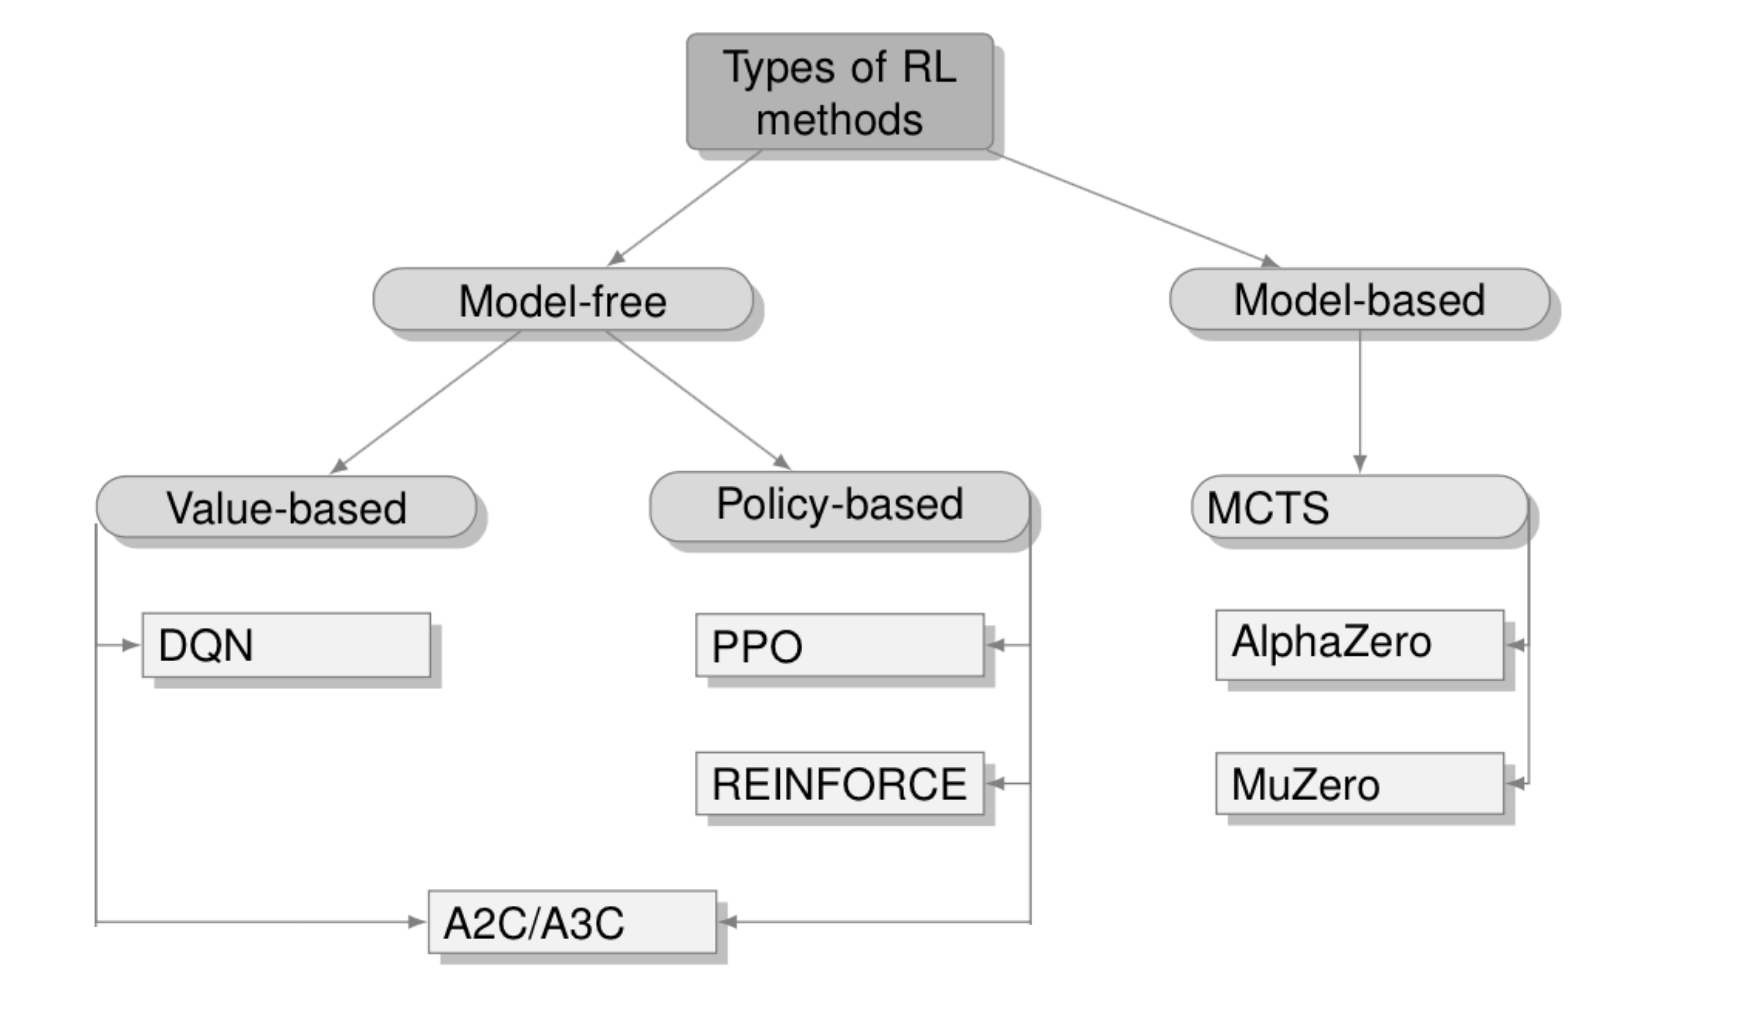

# 1. Value-based methods


We will start with value-based methods. We'll provide a high-level overview and introduce essential terminology, followed by solving the FrozenLake game. Consider an RL agent interacting with an environment. Given a state $s$, the agent's action $a$ is determined by policy $\pi$.

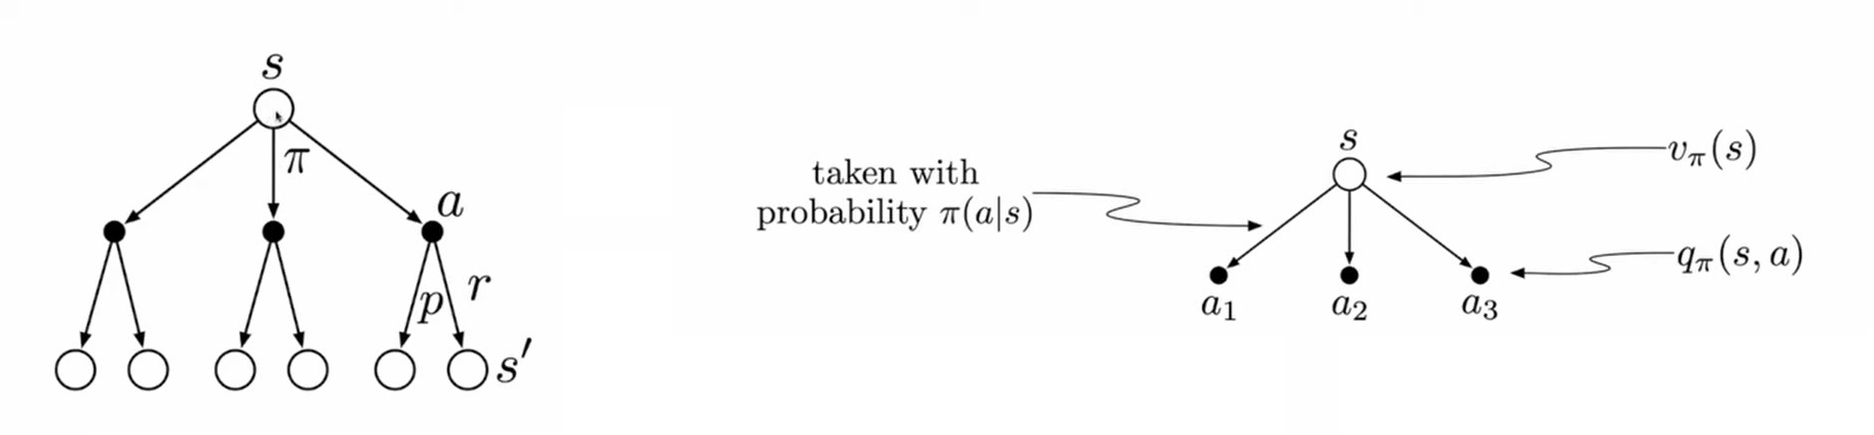


 There are $2$ important notions.

1. **State-value function** $V_{\pi}(s)$ under a policy $\pi$. The value $V_{\pi}(s)$ of a state $s$ is the expected discounted return the agent can get if it starts at that state and then acts according to our policy:
 $$V_{\pi}(s) = \mathbb{E}_{\pi} \left[r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + \dots  \bigr| S_t = s\right].$$

2. **Action-value function** $Q_{\pi}(s,a)$  under a policy $\pi$.  The value $Q_{\pi}(s,a)$ of taking action
 $a$ in state $s$ under a policy $\pi$ is the expected discounted return the agent can get if it starts at that state, performs that action and then acts according to our policy:: $$Q_{\pi}(s, a) = \mathbb{E}_{\pi} \left[r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + \dots  \bigr| S_t = s, A_t = a\right].$$

Here $r_t$ is the local reward obtained at step $t$ of the episode. The total reward could be discounted with $0 < \gamma < 1$ or not discounted (when $\gamma < 1$), it’s up to us how to define it.


* <font color='red'>Question.</font> Assume that we know $V_{\pi^*}(s)$ or $Q_{\pi^*}(s,a)$ for the optimal policy $\pi^*$. How to find the optimal action $a$ in a state $s$?



Notice that we can express $Q(s,a )$ recursively: $$Q(s,a) = r(s,a) + \gamma \max_{a' \in A} Q(s', a').$$ Here the immediate reward is given to us after executing a particular action, $a$, which take the agent from state $s$ to state $s'$. A logical approach is to iteratively estimate $Q(s, a)$ using the Bellman approximation: $$Q(s,a) ← r(s,a) + \gamma \max_{a' \in A} Q(s', a')$$ While analogous formulas exist for $V(s)$, $Q$-functions are generally preferred for practical applications.  It has been shown in [[Sutton, 1988, Theorem 3]](http://incompleteideas.net/papers/sutton-88-with-erratum.pdf) that the function updated by such a rule converges to the optimal
value function.





## 1.1 Q-learning

This leads us to the **tabular Q-learning** method. Assume that the number of states $s$ and actions $a$ is finite.

1. Start with an empty table for $Q(s,a)$, mapping states $s$ to values of actions $a$.
2. By interacting with the environment, obtain the tuple (state, action, reward, and the new state) =  $(s, a, r, s')$. Here we perform *random steps*.

3. Update the $Q(s, a)$ value using the Bellman approximation. It's generally a bad idea to just assign new values on top of existing values, as training can become unstable. Instead we average between old and new values of $Q$ using learning rate $0< \alpha < 1$: $$Q(s,a) ← (1-\alpha)Q(s,a) + \alpha\left( r(s,a) + \gamma \max_{a' \in A} Q(s', a')\right).$$

4. Check convergence conditions. If not met, repeat from Step 2.

In Step 2 we need to decide which action to take. There is no single proper way to make this decision. This is an **Exploration VS Exploitation  problem**.

### 1.1.1 FrozenLake solution

Next, let's use the Q-learing method to solve the FrozenLake game.

In [ ]:
import typing as tt
import gymnasium as gym
from collections import defaultdict
from torch.utils.tensorboard.writer import SummaryWriter

Constants

In [ ]:
State = int
Action = int
ValuesKey = tt.Tuple[State, Action]

ENV_NAME = "FrozenLake-v1"
#ENV_NAME = "FrozenLake8x8-v1"      # uncomment for larger version
GAMMA = 0.9
ALPHA = 0.2
TEST_EPISODES = 20

The goal is get from the top-left corner to the bottom-right without falling into a hole.

*   To make life more complicated, `is_slippery=True`, so the agent's actions do not always turn out as expected - there is a 33% chance that it will rotate to the right or to the left before the move.

In [ ]:
#!/usr/bin/env python3
env = gym.make(ENV_NAME, render_mode="rgb_array")
env.reset()
img = env.render()
plt.imshow(img)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

The tabular Q-learning method is easy to implement. The most interesting part is the `value_update` function in the RL agent.

In [ ]:
class Agent:
    def __init__(self):
        self.env = gym.make(ENV_NAME)
        self.state, _ = self.env.reset()
        self.values: tt.Dict[ValuesKey] = defaultdict(float)

    def sample_env(self) -> tt.Tuple[State, Action, float, State]:
        action = self.env.action_space.sample()
        old_state = self.state
        new_state, reward, is_done, is_tr, _ = self.env.step(action)
        if is_done or is_tr:
            self.state, _ = self.env.reset()
        else:
            self.state = new_state
        return old_state, action, float(reward), new_state

    def best_value_and_action(self, state: State) -> tt.Tuple[float, Action]:
        best_value, best_action = None, None
        for action in range(self.env.action_space.n):
            action_value = self.values[(state, action)]
            if best_value is None or best_value < action_value:
                best_value = action_value
                best_action = action
        return best_value, best_action

    def value_update(self, state: State, action: Action, reward: float, next_state: State):
        '''
        Tabular Q-learing. Update from Step 3.
        '''
        best_val, _ = self.best_value_and_action(next_state)
        new_val = reward + GAMMA * best_val
        old_val = self.values[(state, action)]
        key = (state, action)
        self.values[key] = old_val * (1-ALPHA) + new_val * ALPHA

    def play_episode(self, env: gym.Env) -> float:
        total_reward = 0.0
        state, _ = env.reset()
        while True:
            _, action = self.best_value_and_action(state)
            new_state, reward, is_done, is_tr, _ = env.step(action)
            total_reward += reward
            if is_done or is_tr:
                break
            state = new_state
        return total_reward

Solution:

In [ ]:
test_env = gym.make(ENV_NAME)
agent = Agent()
writer = SummaryWriter(comment="-q-learning")

iter_no = 0
best_reward = 0.0
while True:
    iter_no += 1
    state, action, reward, next_state = agent.sample_env()
    agent.value_update(state, action, reward, next_state)

    test_reward = 0.0
    for _ in range(TEST_EPISODES):
        test_reward += agent.play_episode(test_env)
    test_reward /= TEST_EPISODES
    writer.add_scalar("reward", test_reward, iter_no)
    if test_reward > best_reward:
        print("%d: Best test reward updated %.3f -> %.3f" % (iter_no, best_reward, test_reward))
        best_reward = test_reward
    if test_reward > 0.80:
        print("Solved in %d iterations!" % iter_no)
        break
writer.close()

# 2. Policy-based methods

Next, we discuss **policy-based** RL methods, which aim to discover the optimal policy. Roughly speaking:

*  <font color='blue'>Policy-based methods </font> try to say "*what to do*" in a state.
*  <font color='red'>Value-based methods</font>  focus on "*how good*" a state is.

Policy-based methods are advantageous in environments with numerous or continuous actions, as finding the maximizing action $a = \arg\max_a Q(s, a)$ can be computationally expensive.

A standard approach in policy-based RL, often used in classification, is to output the probability distribution over possible actions. For N actions, the model returns N probabilities, conditioned on the input state.




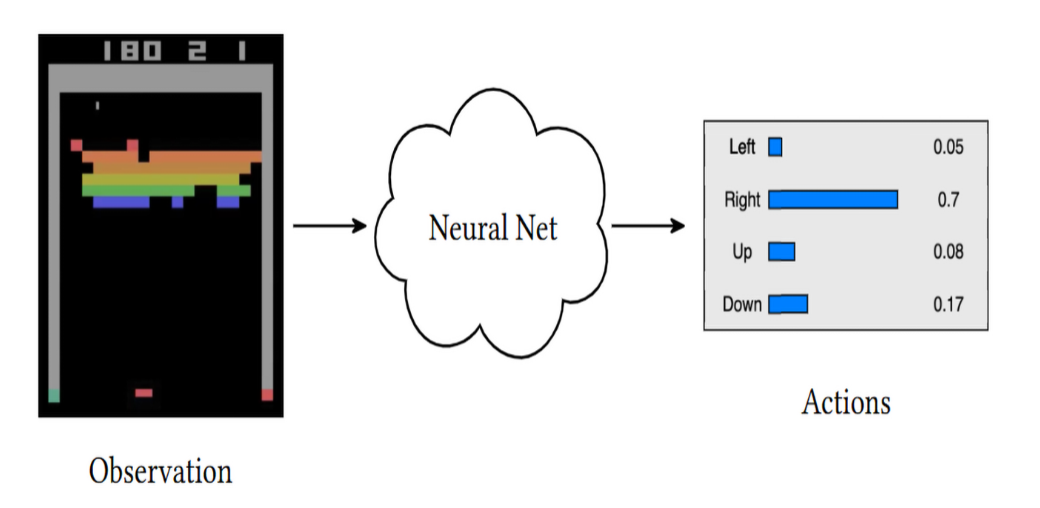

We'll start by introducing the **REINFORCE** method, which is closely related to the cross-entropy method. However, we need to establish some mathematical notations first. The **policy gradient** can be represented as $$\nabla J = \mathbb{E}\left[ Q(s, a) \nabla \log \pi \left( a \bigr| s \right)\right].$$
We've seen proof of this formula in the lecture; also see, e.g., https://lilianweng.github.io/posts/2018-04-08-policy-gradient/ for more details.

The policy gradient defines the direction in which we need to change our network's parameters to improve the policy:

* *The scale of the gradien*t is proportional to the value of the action taken, which is $Q(s,a)$ in the formula.

* The *gradient* is equal to the gradient of the log probability of the action taken. Hence, we are trying to increase the probability of actions that have given us good total rewards and decrease the probability of actions with bad final outcomes.

Expectation, in the formula, just means that we average the gradient of several steps that we have taken in the environment.  In practice, policy gradient methods could be implemented by optimizing the following loss function:
$\mathcal{L}  = -  Q(s,a) \log_{\pi} \left( a \bigr| s \right).$  Note the "minus" sign: the loss function is minimized during stochastic gradient descent (SGD), but we want to maximize our policy gradient. This formula of policy gradient is used by most policy-based methods, but the details can vary. One very important point is how exactly gradient scales $Q (s, a)$, are calculated.



<font color='red'>**Question.**</font> Can cross-entropy method be represented in such way? (**Hint:** $Q(s,a) = 1$ or $0$ for good and bad state and action pairs.)


## 2.1 REINFORCE algorithm

 **REINFORCE** algorithm:

1. Initialize the network with random weights.
2. Play $N$ full episodes, saving their transitions $(s, a, r ,s')$. (Instead of full episodes we can make $M$ steps in the environment.)
3. For every step $t$ and for every episode $k$ calculate the discounted total reward for the subsequent steps: $Q_{k,t} = \sum_{i=t+1}^{\infty}\gamma^i R_i$.
4. Calculate the loss function for all transitions: $$\mathcal{L} = - \sum_{k,t} Q_{k,t}\log(\pi(s_{k,t}, a_{k,t})).$$
5. Perform an SGD update of weights, minimizing the loss.
6. Repeat from step $2$ until convergence is achieved.


### 2.1.1 Baseline

In practice, the policy gradient has high variance, which may lead to unstable training. The usual approach to handling this is subtracting a value called the **baseline** $b$ from the $Q$. The possible choices for the baseline are as follows:

1. Some constant value, which is normally the mean of the discounted rewards
2. The moving average of the discounted rewards
3. The value of the state, $V(s)$.


## 2.2 Example: Solving CartPole environment with REINFORCE

We're keeping things simple by demonstrating Reinforce on the basic CartPole environment.

In [ ]:
#!pip install gymnasium

In [ ]:
#!/usr/bin/env python3
import gymnasium as gym
import numpy as np
import typing as tt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

We take the [CartPole environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/), a classic control problem where you must balance a pole on a moving platform . The challenge lies in preventing the pole from falling by precisely controlling the platform's movements.

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

The observation of this environment is four floating-point numbers containing information about the x coordinate of the stick’s center of mass, its speed, its angle to the platform, and its angular speed.

In [ ]:
obs, info = env.reset()
print(obs)

The  `action_space` field is of the Discrete type, so our actions will be just $0$ or $1$, where $0$ means pushing the platform to the left and $1$ is pushing to the right.

In [ ]:
env.action_space

In [ ]:
import matplotlib.pyplot as plt
env.reset()
img = env.render()
plt.imshow(img)

Constants

In [ ]:
GAMMA = 0.99
LEARNING_RATE = 0.01
EPISODES_TO_TRAIN = 4

State = int
Action = int
Reward = int

Our agent is a simple NN that predicts action probabilities from states.

In [ ]:
class PG_Agent(nn.Module):
    def __init__(self, env, input_size: int, n_actions: int):
        super(PG_Agent, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )

        self.env = env
        self.state = self.env.reset()[0]

    def make_rand_step(self) -> tt.Tuple[State, Action, Reward, State]:
        '''
        Chooose a random action, make one step and return the result
        '''
        state = self.state
        action = self.select_action()
        new_state, reward, is_done, is_trunc, _ = \
                self.env.step(action)
        if is_done or is_trunc:
            self.state, _ = self.env.reset()
            new_state = None
        else:
            self.state = new_state
        return state, action, reward, new_state

    def select_action(self) -> Action:
        '''
        Chooose action with prob given by the policy
        '''
        state = torch.Tensor(self.state)
        logits_v = self.net(state)
        probs_v = F.softmax(logits_v, dim=-1)
        probs = probs_v.data.cpu().numpy()
        action = np.random.choice(len(probs), p=probs)
        return action

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


Function that calculates the discounted total rewards $Q_{k,t} = \sum \gamma^i r_i$.

In [ ]:
def calc_qvals(rewards: tt.List[float], baseline=False) -> tt.List[float]:
    res = []
    sum_r = 0.0
    for r in reversed(rewards):
        sum_r *= GAMMA
        sum_r += r
        res.append(sum_r)
    res = list(reversed(res))
    if baseline:
        mean_q = np.mean(res)
        return [q - mean_q for q in res]
    return res

REINFORCE algorithm

In [ ]:
def reinforce(env, baseline=False, GAMMA=GAMMA,
              LEARNING_RATE = LEARNING_RATE, EPISODES_TO_TRAIN=EPISODES_TO_TRAIN,
              ):

    agent = PG_Agent(env, env.observation_space.shape[0], env.action_space.n)
    print(agent.net)

    optimizer = optim.Adam(agent.net.parameters(), lr=LEARNING_RATE)

    total_rewards = []
    done_episodes = 0

    batch_episodes = 0
    batch_states, batch_actions, batch_qvals = [], [], []
    cur_rewards = []


    step_idx = 0
    while True:
        # print("step", step_idx)
        total_reward = None
        step_idx += 1

        '''
        Step 2. Play full episodes, saving their (s,a,r,s') transitions.
        '''
        state, action, reward, new_state = agent.make_rand_step()
        batch_states.append(state)
        batch_actions.append(action)
        cur_rewards.append(reward)

        if new_state is None:
            '''
            Step 3. Calculate the discounted total reward
            '''
            batch_qvals.extend(calc_qvals(cur_rewards))
            total_reward = sum(cur_rewards)
            cur_rewards.clear()
            batch_episodes += 1


        '''
        Save total rewards at the end of episodes
        Print data every 50 episodes
        '''
        if total_reward:
            done_episodes += 1
            total_rewards.append(total_reward)
            mean_rewards = float(np.mean(total_rewards[-100:]))
            if (done_episodes % 50 == 0):
                print(f"{step_idx}: reward: {total_reward:6.2f}, mean_100: {mean_rewards:6.2f}, "
                  f"episodes: {done_episodes}")
            if mean_rewards > 450:
                print(f"Solved in {step_idx} steps and {done_episodes} episodes!")
                break

        '''
        Making a batch of episodes to train the agent
        '''
        if batch_episodes < EPISODES_TO_TRAIN:
            continue

        optimizer.zero_grad()
        states_t = torch.as_tensor(np.asarray(batch_states))
        batch_actions_t = torch.as_tensor(np.asarray(batch_actions))
        batch_qvals_t = torch.as_tensor(np.asarray(batch_qvals))


        '''
        Step 4. Calculate loss L = -\sum (Q \log \pi) and backpropagate
        '''
        logits_t = agent(states_t) # Predictions of NN
        log_prob_t = F.log_softmax(logits_t, dim=1) # log(\pi(s_{k,t}, a_{k,t}))
        batch_idx = range(len(batch_states))
        act_probs_t = log_prob_t[batch_idx, batch_actions_t]
        log_prob_actions_v = batch_qvals_t * act_probs_t
        loss_t = -log_prob_actions_v.mean()

        loss_t.backward()
        optimizer.step()

        batch_episodes = 0
        batch_states.clear()
        batch_actions.clear()
        batch_qvals.clear()

Our model easily solve the problem.

In [ ]:
env = gym.make("CartPole-v1")
reinforce(env, baseline=False)

Solution with baseline:

In [ ]:
env = gym.make("CartPole-v1")
reinforce(env, baseline=True)

Although REINFORCE offers advantages over cross-entropy, it may still encounter difficulties in environments with sparse rewards. We will subsequently discuss more powerful models, building upon REINFORCE's foundation.

# 3. REINFORCE for Travelling Salesman Problem

Let's recall basic pipeline for solving Combinatorial Optimization problems with RL.

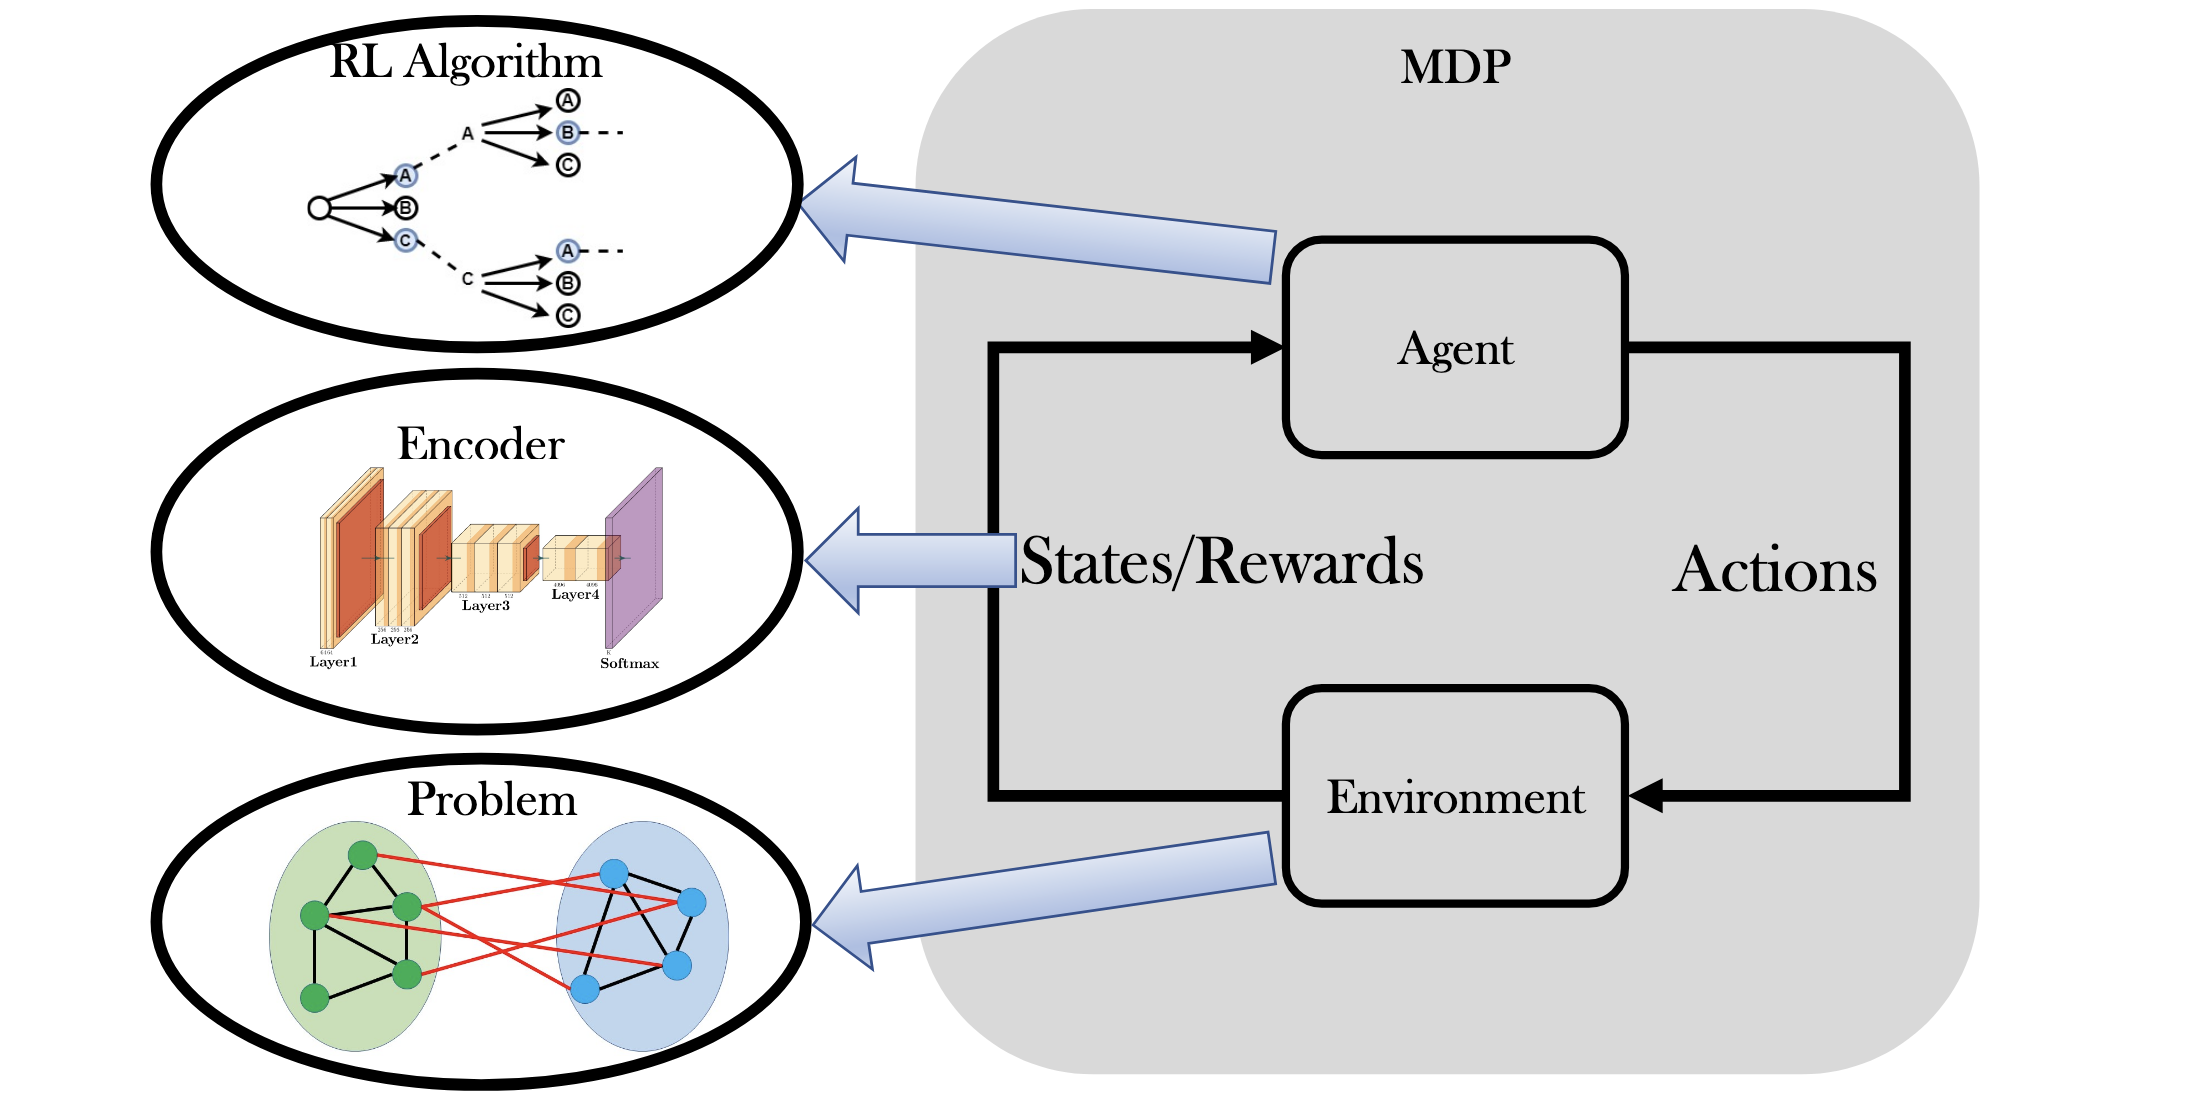

For brief summary see e.g. "Reinforcement Learning for Combinatorial Optimization: A Survey" by N. Mazyavkinaa et al. https://arxiv.org/abs/2003.03600

**Traveling Salesman Problem** (TSP). Given a complete weighted graph $G = (V, E)$, find a tour of minimum total weight, i.e. a cycle of minimum length that visits each node of the graph exactly once.

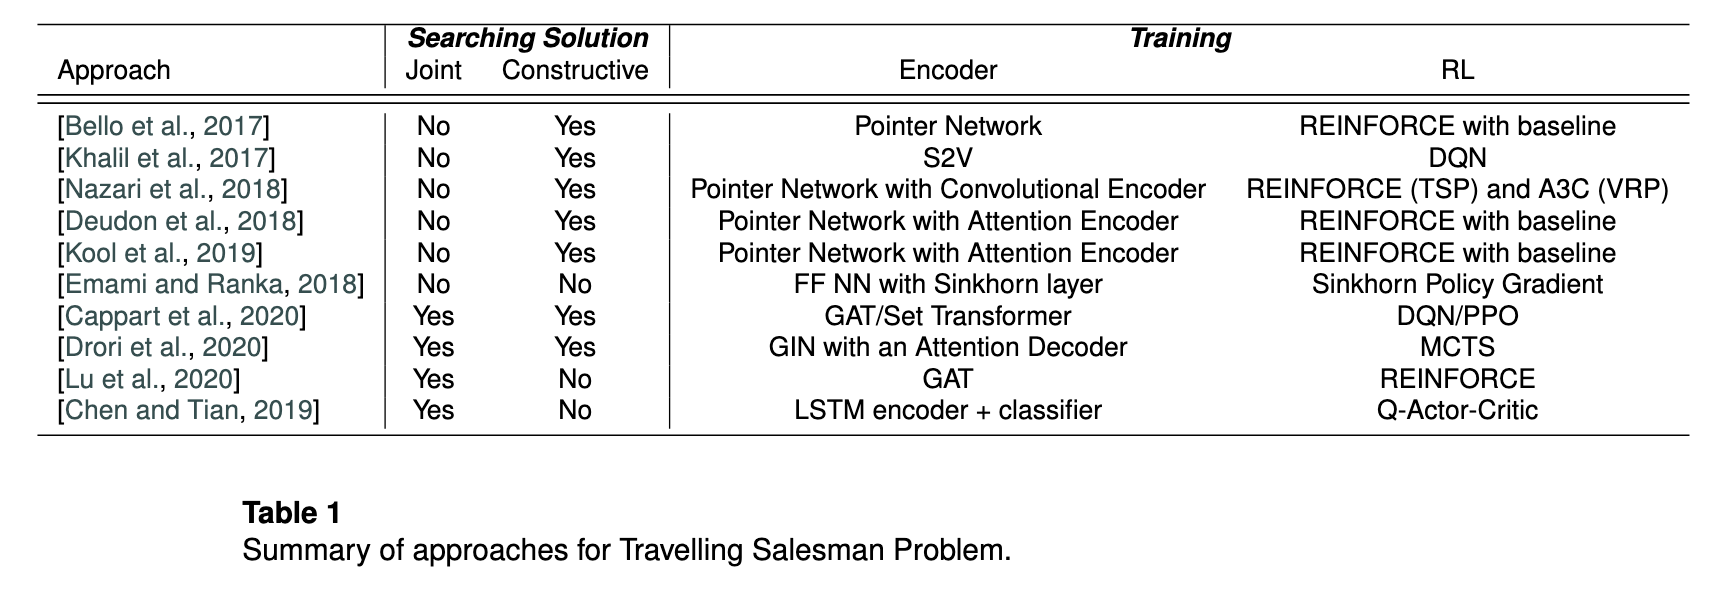

In the table


*   `Joint = Yes` signifies that a solver was utilized in the process.
*   `Constructive = No` indicates iterative improvement of an initial solution, not city-by-city construction.



We demonstrate an implementation of  [[Kool et al., 2019]](https://paperswithcode.com/paper/attention-learn-to-solve-routing-problems).


* They employ a Transformer-like encoder-decoder architecture, trained using a REINFORCE loss with an adjusted baseline.
* The model is trained on batches of 512 instances. Node locations for all TSP instances are sampled uniformly at random within the unit square.

To avoid lots of boileplate code we will use the code from https://github.com/ai4co/rl4co

In this notebook we will train the AttentionModel (AM) on the TSP environment for 50 nodes. On a GPU, this should less than 2 minutes!


In [ ]:
### Installation

## Uncomment the following line to install the package from PyPI
## You may need to restart the runtime in Colab after this
## Remember to choose a GPU runtime for faster training!

%%capture
!pip install rl4co

Imports

In [ ]:
%load_ext autoreload
%autoreload 2

import torch

from rl4co.envs import TSPEnv
from rl4co.models import AttentionModelPolicy, REINFORCE
from rl4co.utils.trainer import RL4COTrainer

Environment, Policy and Model

Full documentation of:https://rl4.co/docs/content/api/envs/base/

- Base environment class [here](https://rl4.co/docs/content/api/envs/base/)
- Base policy class [here](https://rl4.co/docs/content/api/networks/base_policies/)
- Base model class [here](https://rl4.co/docs/content/api/rl/base/)


In [ ]:
# RL4CO env based on TorchRL
env = TSPEnv(generator_params={'num_loc': 50})

# Policy: neural network, in this case with encoder-decoder architecture
policy = AttentionModelPolicy(env_name=env.name,
                              embed_dim=128,
                              num_encoder_layers=3,
                              num_heads=8,
                            )

# RL Model: REINFORCE and greedy rollout baseline
model = REINFORCE(env,
                    policy,
                    baseline="rollout",
                    batch_size=512,
                    train_data_size=100_000,
                    val_data_size=10_000,
                    optimizer_kwargs={"lr": 1e-4},
                    )

Test greedy rollout with untrained model and plot

In [ ]:
# Greedy rollouts over untrained policy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
policy = policy.to(device)
out = policy(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_untrained = out['actions'].cpu().detach()
rewards_untrained = out['reward'].cpu().detach()

for i in range(3):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])

### Trainer

The RL4CO trainer is a wrapper around PyTorch Lightning's `Trainer` class which adds some functionality and more efficient defaults


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
accelerator_type = "gpu" if torch.cuda.is_available() else "cpu"
print(accelerator_type)

In [ ]:
trainer = RL4COTrainer(
    max_epochs=3,
    accelerator=accelerator_type,
    devices=1,
    logger=None,
)

# Training

In [ ]:
trainer.fit(model)

Testing

In [ ]:
# Greedy rollouts over trained model (same states as previous plot)
policy = model.policy.to(device)
out = policy(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))
    env.render(td, actions_untrained[i], ax=axs[0])
    env.render(td, actions_trained[i], ax=axs[1])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

We can see that even after just 3 epochs, our trained AM is able to find much better solutions than the random policy! 🎉

In [ ]:
# Optionally, save the checkpoint for later use (e.g. in tutorials/4-search-methods.ipynb)
trainer.save_checkpoint("tsp-quickstart.ckpt")